# Model comparison using Bayesian evidence
In this notebook, we compare models for a generated data trajectory.
We are given a trajectory of a SEIR model and fit this data with both a SEIR as well as a simpler SIR model.
We compare these models by computing their Bayesian evidence.

Pyross supports evidence computation in two ways.
We can either estimate the evidence exactly (but with random error) using nested sampling or by integrating the Laplace approximation of the model at the MAP estimate.
The second method tends to be faster, but it performs very poorly here.
Part of the problem is the finite difference computation of the Hessian of the log-likelihood, which turns out to be very dependent on the step size `eps`.
Therefore, these results cannot be trusted here.
This is something that should be checked before relying on the Laplace approximation.

In [ ]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

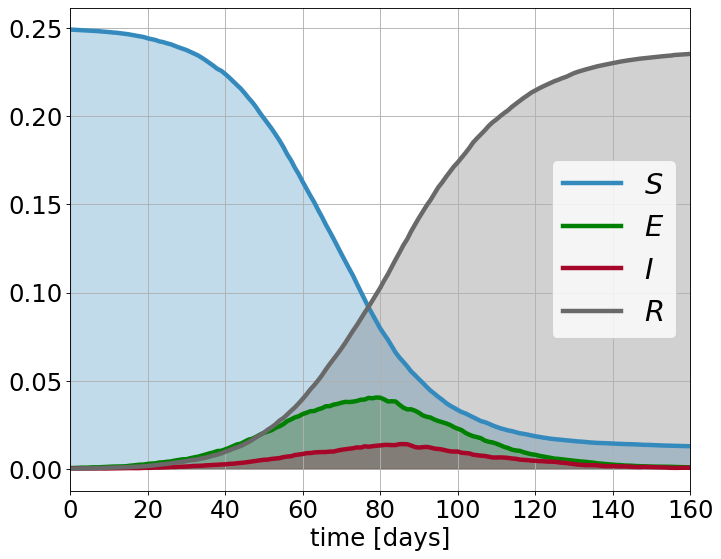

In [3]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Compute the model evidence for the SEIR model
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory.

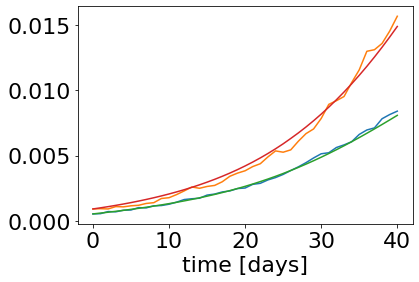

In [4]:
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.plot(obs[:, -2:])
plt.plot(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


In [7]:
# Make parameter guesses (and define bounds for the MAP estimate later)
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    },
    'gE':{
        'mean': 0.1, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}

fsa_g = 0.8 # not inferred 

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 500/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 500/N], M).reshape(M, 2)

init_fltr = np.repeat([False, True, True, False], M)
init_priors = {
    'independent': {
        'fltr': init_fltr,
        'mean': [*E0_g, *Ia0_g],
        'std': [*E_std, *Ia_std],
        'bounds': [*bounds_for_E, *bounds_for_Ia]
    }
}

# start_time = time.time()
# result = estimator.nested_sampling_latent_inference(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,  
#                                                     tangent=True, max_iter=2000, verbose=True, npoints=100) 
# end_time = time.time()
# print(end_time - start_time)

In [53]:
print("Model log-evidence for SEIR (computed by nested sampling): ", result[0])

Model log-evidence for SEIR (computed by nested sampling):  1257.5441652882555


In [54]:
ftol = 1e-9 # the relative tol in (-logp)  

params = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                           tangent=True, global_max_iter=1000, global_atol=0.05, 
                                           cma_population=50, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 8 (seed=2699209454, Mon Jun 29 13:35:58 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.077580261023705e+03 1.0e+00 1.10e+00  3e-04  1e-01 0:01.3
    2    100 -1.233285734423519e+03 1.4e+00 1.19e+00  4e-04  1e-01 0:02.3
    3    150 -1.158341570108775e+03 1.6e+00 1.21e+00  4e-04  1e-01 0:03.4
    6    300 -1.168553428686327e+03 2.3e+00 1.14e+00  3e-04  1e-01 0:06.7
   10    500 -1.244351401367658e+03 3.7e+00 1.28e+00  3e-04  1e-01 0:10.9
   16    800 -1.189114219716061e+03 9.8e+00 1.09e+00  3e-04  9e-02 0:17.0
   22   1100 -1.258952942994375e+03 2.0e+01 1.11e+00  4e-04  9e-02 0:23.7
   28   1400 -1.254864824073741e+03 2.9e+01 9.34e-01  3e-04  7e-02 0:31.1
   35   1750 -1.264960769779057e+03 5.6e+01 6.95e-01  2e-04  3e-02 0:39.5
   43   2150 -1.269390707563454e+03 9.6e+01 8.18e-01  2e-04  3e-02 0:50.3
   52   2600 -1.269898192762645e+03 1.6e+02 1.05e+00  3e-04

/home/paul/Sys/Programme/anaconda3/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=214)
  ')')


  218  10900 -1.271898839752550e+03 1.8e+00 1.89e-03  1e-03  2e-03 3:59.6
  238  11900 -1.271898839752939e+03 1.3e+01 1.20e-03  2e-04  9e-04 4:22.2
  259  12950 -1.271898839753006e+03 5.1e+01 5.34e-04  5e-05  2e-04 4:45.9
  263  13150 -1.271898839753006e+03 5.7e+01 4.12e-04  3e-05  2e-04 4:50.5
Optimal value (global minimisation):  -1271.8988397530163
Starting local minimisation...
Optimal value (local minimisation):  -1271.898839753017
489.10261631011963


In [33]:
# The finite difference computation of the Hessian turns out to be a major problem here. Slightly varying the eps parameters
# gives substantially different results, which means that these results cannot be trusted.
log_evidence = estimator.log_G_evidence_latent(param_keys, init_fltr, params, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                               contactMatrix, tangent=True, eps=5e-2*params)

In [34]:
print("Model log-evidence for SEIR (computed by Laplace approximation): ", log_evidence) 

Model log-evidence for SEIR (computed by Laplace approximation):  1209.2568304303607


### 2.1) Plot samples of the posterior, posterior mean and MAP estimate

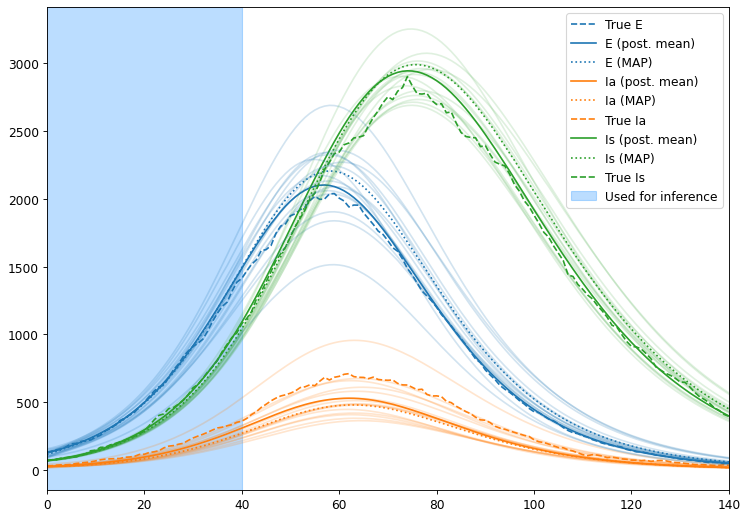

In [58]:
post_mean = pyross.utils.posterior_mean(result[1])
estimator.set_params(post_mean['map_params_dict'])
estimator.set_det_model(post_mean['map_params_dict'])
x_pm = estimator.integrate(post_mean['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N
estimator.set_params(params['map_params_dict'])
estimator.set_det_model(params['map_params_dict'])
x_map = estimator.integrate(params['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x[:,M], label='True E', c="C0", linestyle='dashed')
plt.plot(x_pm[:, M], label='E (post. mean)', c="C0")
plt.plot(x_map[:, M], label='E (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Ia (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Ia (MAP)', c="C1", linestyle='dotted')
plt.plot(x[:,2*M], label='True Ia', c="C1", linestyle='dashed')
plt.plot(np.sum(x_pm[:, 3*M:], axis=1), label='Is (post. mean)', c="C2")
plt.plot(np.sum(x_map[:, 3*M:], axis=1), label='Is (MAP)', c="C2", linestyle='dotted')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is', c="C2", linestyle='dashed')
for sample in pyross.utils.resample(result[1], 20):
    estimator.set_params(sample['map_params_dict'])
    estimator.set_det_model(sample['map_params_dict'])
    x_det = estimator.integrate(sample['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)
    plt.plot(np.sum(x_det[:, 3*M:], axis=1), c="C2", alpha=0.15)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()

## 3) Compute the model evidence for the SIR model
We take the same data points as in 2).

In [8]:
estimator2 = pyross.inference.SIR(parameters, M, fi, int(N), steps)

eps = 1e-3

fltr2=np.kron([[1, 1, 1], [0, 0, 1]], np.identity(M))
obs2=np.einsum('ij,kj->ki', fltr, x) 
x02=x[0]

param_priors2 = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}
init_fltr2 = np.repeat([False, True, False], M)
init_priors2 = {
    'independent':{
        'fltr': init_fltr2, 
        'mean': [*Ia0_g], 
        'std': [*Ia_std], 
        'bounds': [*bounds_for_Ia]
    }
}

start_time = time.time()
result2 = estimator2.nested_sampling_latent_inference(obs2, fltr2, Tf_inference, contactMatrix, param_priors2, init_priors2,  
                                                    tangent=True, max_iter=2000, verbose=True, npoints=100) 
end_time = time.time()
print(end_time - start_time)

Iteration 100: log_evidence = -21848.67206759324
Iteration 200: log_evidence = 594.5182787513369
Iteration 300: log_evidence = 1064.2382235858163
Iteration 400: log_evidence = 1158.6328909796805
Iteration 500: log_evidence = 1191.335977520829
Iteration 600: log_evidence = 1205.1109370607812
Iteration 700: log_evidence = 1210.5484293458283
Iteration 800: log_evidence = 1213.5084366754947
Iteration 900: log_evidence = 1215.5447294204325
Iteration 1000: log_evidence = 1216.5117815419296
Iteration 1100: log_evidence = 1217.0433441454447
128.43130087852478


In [21]:
print("Model log-evidence for SIR (computed by nested sampling): ", result2[0])

Model log-evidence for SIR (computed by nested sampling):  1240.3514698511665


In [9]:
ftol = 1e-9 # the relative tol in (-logp)  

params2 = estimator2.latent_infer_parameters(obs2, fltr2, Tf_inference, contactMatrix, param_priors2, init_priors2,
                                           tangent=True, global_max_iter=200, global_atol=0.1, 
                                           cma_population=50, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 5 (seed=2569239896, Mon Jun 29 13:45:15 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.195556209267293e+03 1.0e+00 1.11e+00  4e-04  1e-01 0:01.3
    2    100 -1.087642808331532e+03 1.5e+00 9.65e-01  4e-04  1e-01 0:02.3
    3    150 -1.194322854540814e+03 1.9e+00 9.39e-01  4e-04  1e-01 0:03.4
    6    300 -8.828136689570746e+02 3.9e+00 8.28e-01  4e-04  1e-01 0:07.1
   11    550 -1.192850438084630e+03 4.8e+00 8.17e-01  2e-04  1e-01 0:11.9
   17    850 -1.088473028505957e+03 5.2e+00 6.97e-01  2e-04  7e-02 0:18.9
   22   1100 -1.187339218769911e+03 5.0e+00 6.59e-01  2e-04  9e-02 0:27.1
   28   1400 -1.205679829806114e+03 1.2e+01 7.81e-01  2e-04  7e-02 0:35.8
   35   1750 -1.224748995446929e+03 6.8e+01 1.06e+00  2e-04  3e-02 0:44.4
   43   2150 -1.227828430282748e+03 2.0e+02 7.85e-01  1e-04  1e-02 0:53.6
   51   2550 -1.228769100311383e+03 4.3e+02 2.56e+00  3e-04

In [29]:
# The finite difference computation of the Hessian turns out to be a major problem here. Slightly varying the eps parameters
# gives substantially different results, which means that these results cannot be trusted.
log_evidence = estimator2.log_G_evidence_latent(param_keys2, init_fltr2, params2, guess2, stds2, obs2, fltr2, Tf_inference, Nf_inference, 
                                                contactMatrix, tangent=True, eps=1e-2*params2)

In [30]:
print("Model log-evidence for SIR (computed by Laplace approximation): ", log_evidence) 

Model log-evidence for SIR (computed by Laplace approximation):  1214.7028763019462


We can see that when using nested sampling, our methodology suggests that SEIR is the better model for our data (which has indeed been generated using a SEIR model).

### 3.1) Plot samples of the posterior, posterior mean and MAP estimate

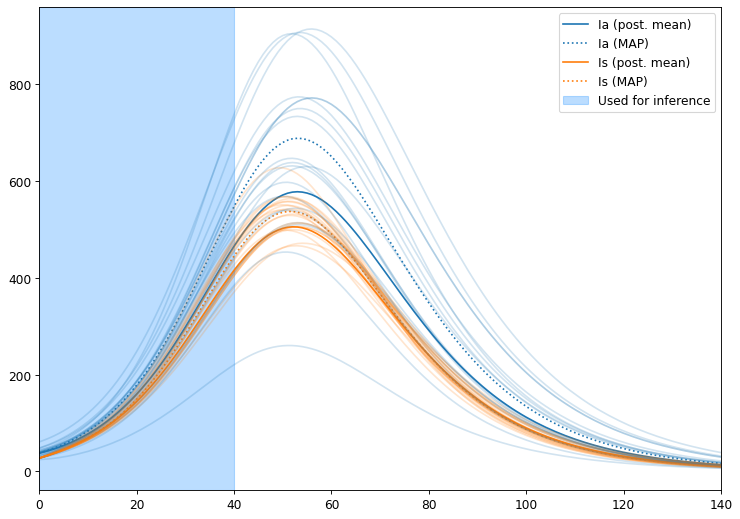

In [16]:
post_mean = pyross.utils.posterior_mean(result2[1])
estimator2.set_params(post_mean['map_params_dict'])
estimator2.set_det_model(post_mean['map_params_dict'])
x_pm = estimator2.integrate(post_mean['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N
estimator2.set_params(params2['map_params_dict'])
estimator2.set_det_model(params2['map_params_dict'])
x_map = estimator2.integrate(params2['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N

fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x_pm[:, M], label='Ia (post. mean)', c="C0")
plt.plot(x_map[:, M], label='Ia (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Is (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Is (MAP)', c="C1", linestyle='dotted')
for sample in pyross.utils.resample(result2[1], 20):
    estimator2.set_params(sample['map_params_dict'])
    estimator2.set_det_model(sample['map_params_dict'])
    x_det = estimator2.integrate(sample['map_x0'], N_start-1, Tf, Nf-N_start, method='LSODA') * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)
#     plt.plot(np.sum(x_det[:, 3*M:], axis=1), c="C2", alpha=0.15)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()